In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from IPython.display import display

In [2]:
%load_ext autoreload
%autoreload 2

<!--
Copyright 2023 Anastasia Bugaenko
-->
# Finite-Size Scaling by method of least-sqaures
The finite-size scaling (FSS) method is a powerful tool that enables extraction of exponent of critical phenomena. Given data describing some dimensionless quantity, we estimate universal information from observables at finite-size system. The derivation of such scaling laws is supported by the renormalization-group argument. This notebook introduces a FSS based on the method of Leas-squares (LS) as performed by [Patzelt, Felix, and Jean-Philippe Bouchaud, 2018.](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.97.012304)

- Anastasia Bugaenko and Christian Wayi-Wayi: (in preparation).

## Finite-size scaling of non-equilibrium phenomena
The fiite-size scaling (FSS) law describes a case where the properties of probability distribution $p(x)$ and function (observable or curve) $\mathscr{F}(x)$ of a system remain unchanged under any linear rescaling of the spatial or temporal random variate $x$.  Whereas in statistical mechanics the renormalisation occurs in space, for non-equilibrium problems the renormalisation occurs in time [Goldenfeld, Nigel, 2018.](https://www.taylorfrancis.com/books/mono/10.1201/9780429493492/lectures-phase-transitions-renormalization-group-nigel-goldenfeld) This can be written as
$$
A\left(x, T\right) = T^{\chi} \mathscr{F}\left(xT^{-\varkappa}\right),
$$
wherein $x$ is a variable describing a physical system of which size is $T$. The exponents $\chi$ and $\varkappa$ are critical exponents with the critical point located at $x = T = 0$, and $\mathscr{F}(\cdot)$ is a scaling function which too exhibits universality. Thus, the FSS analysis is an inference of critical exponents $\theta_c = (\chi, \varkappa)$ that describe the observable.

## Modeling a scaling function using a closed-form analytical expression of relationship between Volume Imbalance and Price Response

### Preparation
The following modules are required

In [5]:
from liquidity.features import compute_aggregate_features

from market_impact.response_functions import aggregate_impact
from market_impact.util.utils import bin_data_into_quantiles, smooth_outliers

In [8]:
from market_impact.fss import fit_scaling_form, fit_scaling_law
from market_impact.function_form import scaling_function, scaling_form, scaling_law

from market_impact.util.plot import plot_scaling_form, plot_scaling_law

In [9]:
BIN_SIZE = list(range(1, 150))
OBSERVATION_WINDOWS = [5, 10, 20, 50, 100]

The following are special modules for conducting the FSS by method of LS.

In [10]:
from market_impact.fss import find_shape_parameters, find_scale_factors, transform

### Dataset
We first prepare the data. Each entry of the orderbook data correpsonds to a single event of type $\pi$ (trade execution $MO$, limit order $LO$ deposit or cancellation $CA$, queues of active order $QA$) in the orderbook for a given asset (say a stock, APPL or TSLA).

In [11]:
current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..')
data_dir = os.path.join(root_dir, 'dataset', 'MO_sample')
filename = "AAPL-2017-NEW.csv" # APPLE Example
stock_file_path = os.path.join(data_dir, filename)
aapl_orderbook_states = pd.read_csv(stock_file_path)
display(aapl_orderbook_states)

,Unnamed: 0,event_timestamp,sign,side,lob_action,order_executed,execution_price,size,ask,bid,...,average_vol_at_best,midprice_change,R1,spread,date,daily_R1,daily_vol,daily_num,norm_size,signed_volume
0,0,2017-01-03 10:30:00.544161131,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.000,0.000,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
1,1,2017-01-03 10:30:02.758712611,-1,BID,REMOVE,True,115.69,153,115.70,115.69,...,762.184840,-0.010,0.010,0.01,2017-01-03,0.004271,1398089,6170,0.200739,-153
2,2,2017-01-03 10:30:02.852790059,1,ASK,REMOVE,True,115.69,200,115.69,115.68,...,1045.040418,0.010,0.010,0.01,2017-01-03,0.004271,1398089,6170,0.191380,200
3,3,2017-01-03 10:30:04.539218241,1,ASK,REMOVE,True,115.70,100,115.70,115.69,...,1045.040418,0.000,0.000,0.01,2017-01-03,0.004271,1398089,6170,0.095690,100
4,4,2017-01-03 10:30:07.865732286,1,ASK,UPDATE,True,115.70,10,115.70,115.69,...,1045.040418,0.000,0.000,0.01,2017-01-03,0.004271,1398089,6170,0.009569,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2633973,6730,2017-12-29 14:59:22.595997049,1,ASK,REMOVE,True,169.99,200,169.99,169.98,...,773.098946,0.005,0.005,0.01,2017-12-29,0.030568,1452499,6735,0.258699,200
2633974,6731,2017-12-29 14:59:26.825179397,1,ASK,REMOVE,True,170.00,1200,170.00,169.98,...,773.098946,0.005,0.005,0.02,2017-12-29,0.030568,1452499,6735,1.552195,1200
2633975,6732,2017-12-29 14:59:58.621436793,-1,BID,UPDATE,True,169.99,300,170.00,169.99,...,725.867637,0.000,-0.000,0.01,2017-12-29,0.030568,1452499,6735,0.413298,-300
2633976,6733,2017-12-29 14:59:58.621758027,-1,BID,REMOVE,True,169.99,205,170.00,169.99,...,725.867637,-0.010,0.010,0.01,2017-12-29,0.030568,1452499,6735,0.282421,-205


### Conditional aggregate impact
 We first coarse-grain this data into different bin sizes, we marginalize over microscopic degrees of freedom in the system to yield an effective coarse-grained description at long distances.

In [12]:
aggregate_features = compute_aggregate_features(aapl_orderbook_states, BIN_SIZE)
display(aggregate_features)

,event_timestamp,midprice,sign,signed_volume,price_changing,daily_R1,daily_num,daily_vol,volume_imbalance,sign_imbalance,price_change_imbalance,average_vol_at_best,T
0,2017-01-03 10:30:00.544161131,115.695,1,100,True,0.004271,6170,1398089,100,1,1,1045.040418,1
1,2017-01-03 10:30:02.758712611,115.695,-1,-153,True,0.004271,6170,1398089,-153,-1,1,762.184840,1
2,2017-01-03 10:30:02.852790059,115.685,1,200,True,0.004271,6170,1398089,200,1,1,1045.040418,1
3,2017-01-03 10:30:04.539218241,115.695,1,100,True,0.004271,6170,1398089,100,1,1,1045.040418,1
4,2017-01-03 10:30:07.865732286,115.695,1,10,False,0.004271,6170,1398089,10,1,0,1045.040418,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17673,2017-12-29 14:13:10.007904919,169.965,1,700,True,0.030568,6735,1452499,-1029,9,78,773.098946,149
17674,2017-12-29 14:21:47.238059427,170.005,-1,-17,False,0.030568,6735,1452499,-12965,-27,79,725.867637,149
17675,2017-12-29 14:35:36.652311807,169.945,1,3,True,0.030568,6735,1452499,-5659,1,61,773.098946,149
17676,2017-12-29 14:44:14.692711793,169.985,-1,-71,True,0.030568,6735,1452499,-9528,-21,80,725.867637,149


### Data normalization

From aggregate features, we can then compute conditional aggregate impact. Each line of our feature data will be converted into an aggregate impact dataframe consisting of three values {system size $T$, temperature $x$, observable $A$}. In our case these correspond to the contemporaneous bin size $T$, orderflow imbalance $\Delta V$ and aggregate returns $R$ respectively.

All data are automatically rescaled in preparation for a finite-size scaling. In particular, the temperature $\Delta V$ and observable $R$ are rescaled each day by their corresponding values of $\mathcal{R}(1)$ and either the average queue volume $\overline{V}_{\mathrm{best}}$ or daily volume  $V_D$  that represent constants of unit dimension and define a characteristic length scale. A similar rescaling works well for different asset instruments and asset classes.

In [13]:
# Compute data for susceptibility
normalized_data = aggregate_impact(aggregate_features, conditional_variable="volume_imbalance") # normalization_constant="volume_at_best"
display(normalized_data)

,T,volume_imbalance,R
0,1,0.000072,0.000000
1,1,-0.000109,-2.341556
2,1,0.000143,2.341556
3,1,0.000072,0.000000
4,1,0.000007,0.000000
...,...,...,...
17673,149,-0.000708,1.308561
17674,149,-0.008926,-1.962842
17675,149,-0.003896,1.308561
17676,149,-0.006560,-0.163570


## Do the FSS

### $1.$ Determine shape parameters $\alpha$ and $\beta$
In order to determine the shape paremeters, the shape, the scaling form $R(\Delta V^\prime, T)$ is fitted for $\textit{all}$ $Ts$using the scaling form Eq. X.

In [14]:
alpha, beta = find_shape_parameters(normalized_data, reflect_y=False, imbalance_column="volume_imbalance")
print(f'alpha: {alpha}')
print(f'beta: {beta}')

alpha: 0.524603650600512
beta: 2.706288366380384


### $2.$ Map out scale factors $V_T$ and $R_T$ and determine their behaviour.

In order to determine the scaling behaviour and rescaling exponents $\chi$ and $\varkappa$ that follow, the shape of RN(\Delta V, T) is fitted for $\textit{each}$ T using the scaling form Eq. X with the scaling function $\mathscr{F}(x)$ given by Eq. X whilst keeping the previously found values values of $\alpha$ nad $\beta$ constant. Note that the fitting of the scaling form to aggregate impact data that yield $R_T, V_T$ for each $T$ does not impose any assumptions on their scaling.

In [15]:
RT_series, VT_series, RT_fit_object, VT_fit_object, fit_results_per_lag = find_scale_factors(normalized_data, alpha=alpha, beta=beta, reflect_y=False)

[]

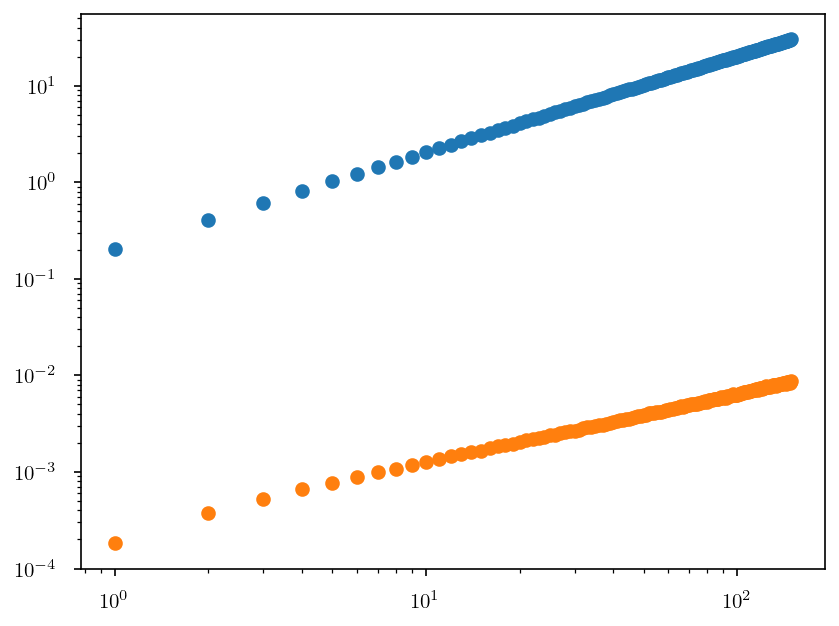

In [16]:
# Plot scale factors RN and QN
plt.scatter(RT_series['x_values'],RT_series['y_values'])
plt.scatter(VT_series['x_values'],VT_series['y_values'])
plt.loglog()

#### $2.2.$ From mapped out scale factors, determine scaling exponents $\chi$ and $\varkappa$

In [17]:
chi = RT_fit_object.powerlaw.params.alpha
kappa = VT_fit_object.powerlaw.params.alpha
print(chi)
print(kappa)

0.9974642253181752
0.7297068387374152



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 11.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.20514043641567317
alpha = 0.9974642253181752

Goodness of fit to data;
D = 0.007194244604316547
bic = -1581.7798466797685
mape = 0.016714966903486738
Adjusted R-squared = 0.9999998408152859



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 11.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.00022325955521759815
alpha = 0.7297068387374152

Goodness of fit to data;
D = 0.02158273381294964
bic = -2645.425773752919
mape = 1.1406721701781546
Adjusted R-squared = 0.9988326496617586




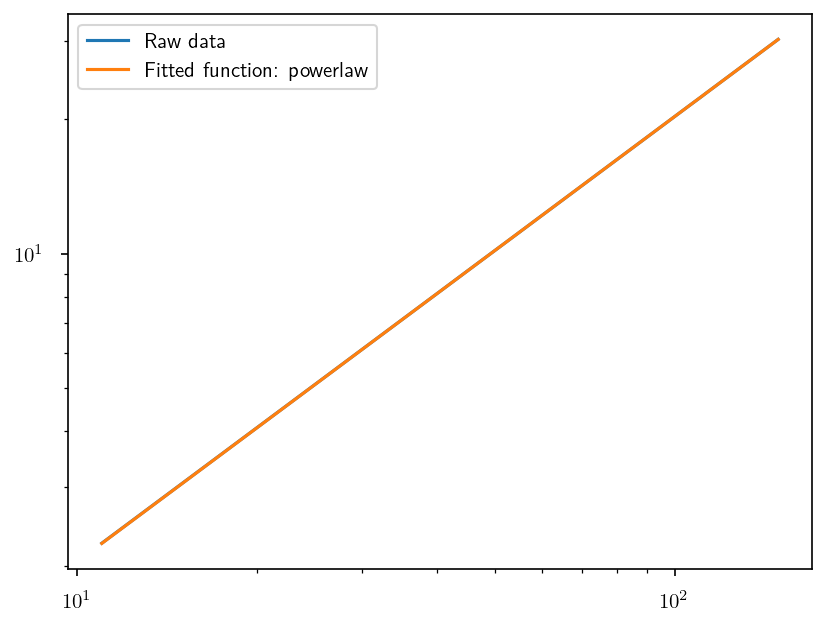

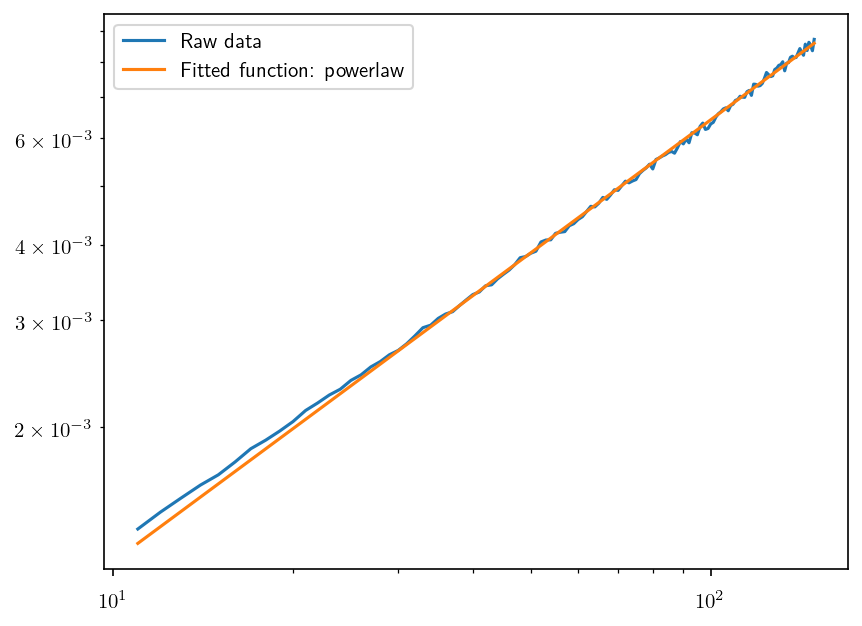

In [18]:
# Fit results
RT_fit_object.powerlaw.fit_results()
VT_fit_object.powerlaw.fit_results()
RT_fit_object.powerlaw.plot_fit()
VT_fit_object.powerlaw.plot_fit()

In [19]:
# Compare scaling of Height against alternative heavy-tailed hypothesis
print("Power law vs. powerlaw_with_exp_svf")
R, p = RT_fit_object.function_compare("powerlaw", "exponential_function")
R, p = RT_fit_object.function_compare("powerlaw", "lognormal_function")

display(RT_fit_object.return_all_fitting_results())

Power law vs. powerlaw_with_exp_svf


,name,xmin_index,xmin,fitting param,D,bic,mape,adjusted r-squared
0,powerlaw,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.2051404...",0.0072,-1581.7798,0.0167,1.0000
1,OLS,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.2053549...",0.0072,-1550.6966,0.0146,1.0000
2,GeneralisedRegression,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.2053549...",0.0072,-1550.6966,0.0146,1.0000
3,RobustRegression,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.2053432...",0.0072,-1556.3780,0.0145,1.0000
4,exponential_function,10,11.0,"{'param_names': ['beta', 'lambda_'], 'beta': 5...",0.1511,164.9240,18.7040,0.9544
5,lognormal_function,10,11.0,"{'param_names': ['mu', 'sigma'], 'mu': 0.0, 's...",1.0000,820.5333,100.0000,-4.1020


In [20]:
# Compare scaling of Width against alternative heavy-tailed hypothesis
print("Power law vs. powerlaw_with_exp_svf")
R, p = VT_fit_object.function_compare("powerlaw", "exponential_function")
R, p = VT_fit_object.function_compare("powerlaw", "lognormal_function")

display(VT_fit_object.return_all_fitting_results())

Power law vs. powerlaw_with_exp_svf


,name,xmin_index,xmin,fitting param,D,bic,mape,adjusted r-squared
0,powerlaw,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.0002232...",0.0216,-2645.4258,1.1407,0.9988
1,OLS,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.0002374...",0.0288,-2616.1314,1.0401,0.9986
2,GeneralisedRegression,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.0002374...",0.0288,-2616.1314,1.0401,0.9986
3,RobustRegression,10,11.0,"{'param_names': ['C', 'alpha'], 'C': 0.0002368...",0.0288,-2616.1300,1.0355,0.9986
4,exponential_function,10,11.0,"{'param_names': ['beta', 'lambda_'], 'beta': 0...",0.1367,-2121.3200,11.0687,0.9493
5,lognormal_function,10,11.0,"{'param_names': ['mu', 'sigma'], 'mu': 0.0, 's...",1.0000,-1421.7666,100.0000,-6.7701


### $3.1$ Plot the scaling law before and after the transformation/ renomalization

We can now substitute the found emeprical scaling laws for RN and QN and use this law fit the final shape parameters $\alpha$ and $\beta$, and rescaling exponents $\chi$ and $\varkappa$.

In [21]:
# Plot final rescaled functions
OBSERVATION_WINDOWS = [x for x in OBSERVATION_WINDOWS if x in VT_series['x_values'].values]

# Smooth data for plotting purposes
smoothed_data = smooth_outliers(normalized_data.copy())

fit_param = {}
for T in OBSERVATION_WINDOWS:
    data = normalized_data[normalized_data['T']==T][["T", "volume_imbalance", "R"]]
    data.replace([np.inf, -np.inf], np.nan, inplace=False)
    data.dropna(inplace=True)

    binned_data = bin_data_into_quantiles(data, q=len(BIN_SIZE), duplicates="drop")

    T_values = binned_data['T'].values
    volume_imbalance = binned_data['volume_imbalance'].values
    R_values = binned_data['R'].values

    params = fit_scaling_form(T_values, volume_imbalance, R_values, reflect_y=False)
    fit_param[T] = params

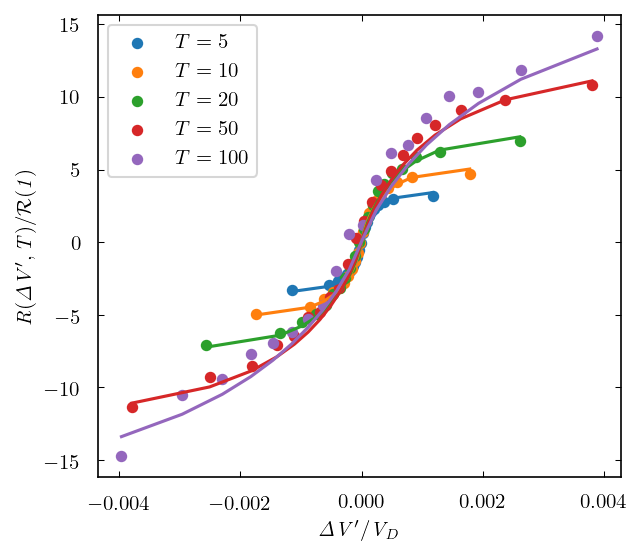

In [22]:
plot_scaling_form(smoothed_data=smoothed_data, fit_parameters=fit_param, q=21)

#### $3.1.$ Transformer function
The transformer function defines the transformation of our three variables to the new variables $(X, Y)$. It needs the initial values of the shape parameters, critical exponents $\chi$ and $\varkappa$ from the master curve (scaling law) to perform the renormalization by method of least_squares.

In [23]:
# Prepare the data for fitting
T_values = normalized_data['T'].values
volume_imbalance_values = normalized_data['volume_imbalance'].values
R_values = normalized_data['R'].values

# Fit data for all Ts
master_curve_param = fit_scaling_law(T_values, volume_imbalance_values, R_values, reflect_y=False)



In [24]:
# Retrieve optimized parameters as constants
chi, kappa, alpha, beta, CONST = master_curve_param
print(f'chi: {chi}')
print(f'kappa: {kappa}')
print(f'alpha: {alpha}')
print(f'beta: {beta}')
print(f'CONST: {CONST}')

chi: 0.5815543378395173
kappa: 0.9176168449583451
alpha: 0.401916872341553
beta: 30.315944653819344
CONST: 68326.45750375345


In [25]:
# Transform/ normalize scaling parameters
rescaled_params = transform(smoothed_data, master_curve_param, OBSERVATION_WINDOWS, reflect_y=False)

We plot a scaling function rescaled by critical paramters $\chi$ and $\varkappa$.

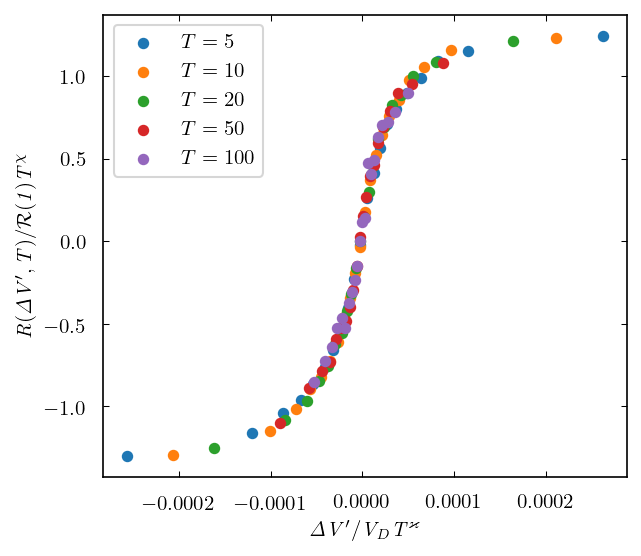

In [26]:
plot_scaling_law(rescaled_parameters=rescaled_params, q=21)

In [23]:
# TODO: Also return new paramters after transform